In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils.class_weight import compute_sample_weight

In [45]:
data = pd.read_csv('data/creditcard.csv')

In [46]:
 weight = compute_sample_weight(class_weight='balanced', y=data['Class'])

In [48]:
data['weight'] = weight

In [50]:
data['weight'].value_counts()

0.500865      284315
289.438008       492
Name: weight, dtype: int64

Il modello non è in grado di generalizzare bene. comunque alla fine del tuning nonostante le metriche promettenti in test set performa molto male. Visti gli score di validation probabilmetne il modello è in overfitting.
idee per migliorare:
1) rivedere il feature space. ok in corso. eta meglio upper bound 0.4. forse spegnere reg alfa, lambda  e gamma
2) monitorare il training con la learning_curve di sklearn.
3) migliorare il sampling del modello. o si umentano i boosting round per assicurarsi che il modello riesca a fare abbastanza round da generalizzare il dataset -> monitorare durante il tuning il numero di roud di ogni ciclo di tuning. ok fatto
4) cambiare metodo di sampling. effettuare random undersampling all'inizio.
5) se si usano metodi di sampling disattivare parametri per contollare lo sbilanciamento del target. ok ha funzionato
6) capire comei mplementare l'algoritmo sulla gpu

In [55]:
thresh = pd.read_csv("results/xgboostTuning_data_treshold.csv")

In [56]:
fscore = (2 * thresh['precision'] * thresh['recall']) / (thresh['precision'] + thresh['recall'])
# locate the index of the largest f score
fscore=list(fscore)

In [57]:
fscore_s=sorted(fscore, reverse=True)

In [58]:
thre=[]
for i in range(0, 10):
    thre.append(fscore.index(fscore_s[i]))

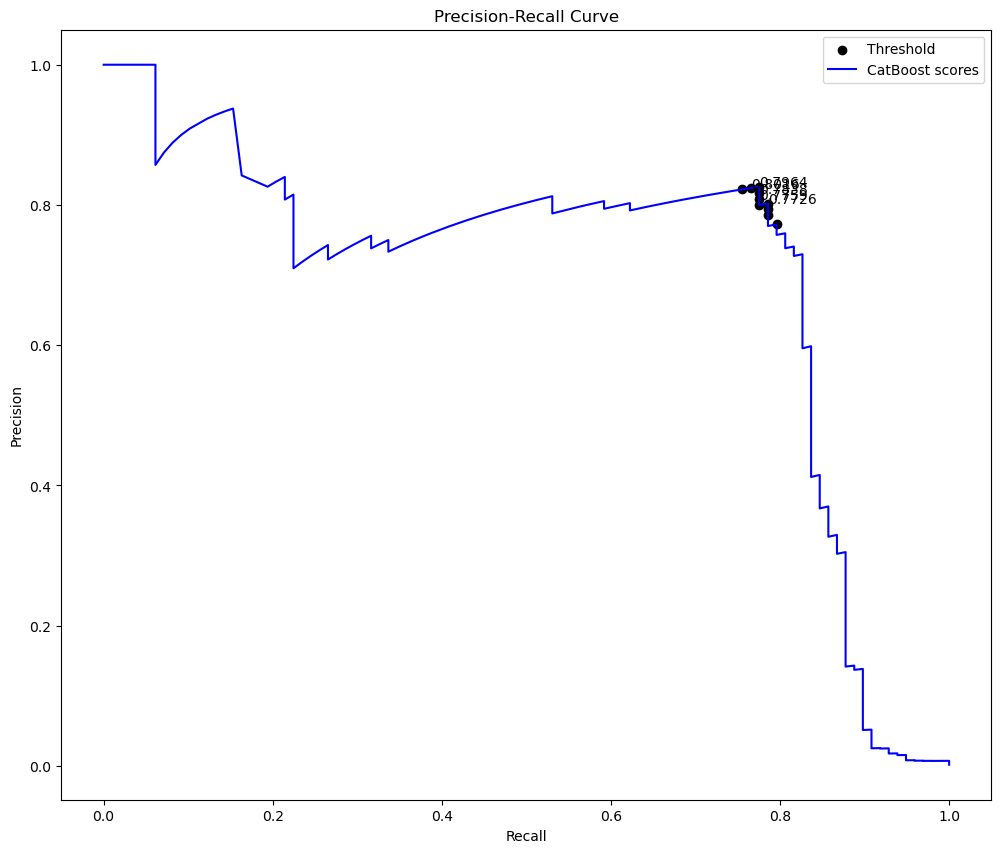

In [59]:
#create precision recall curve
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(thresh['recall'][thre], thresh['precision'][thre], marker='o', color='black', label='Threshold')
for i in range(0,5):
    ax.annotate(round(thresh['thresholds'][thre[i]],4), xy=(thresh['recall'][thre][thre[i]], thresh['precision'][thre[i]]))
ax.plot(thresh['recall'], thresh['precision'], color='blue', label='CatBoost scores')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
#display plot
plt.legend()
plt.show()

In [60]:
results = pd.read_csv("results/xgboostTuning_results.csv")

In [61]:
results.columns

Index(['max_depth', 'recall', 'precision', 'f1_val', 'f1_train', 'eta',
       'max_bin', 'reg_alpha', 'colsample_bytree', 'subsample', 'gamma',
       'loss'],
      dtype='object')

In [62]:
results['cum_loss'] = results.loss.cummin()

Text(0, 0.5, 'best_cumulative_score')

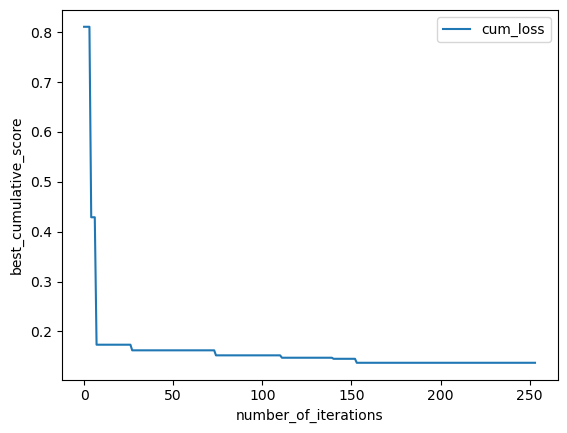

In [63]:
ax = results[['cum_loss']].plot()

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

<Axes: >

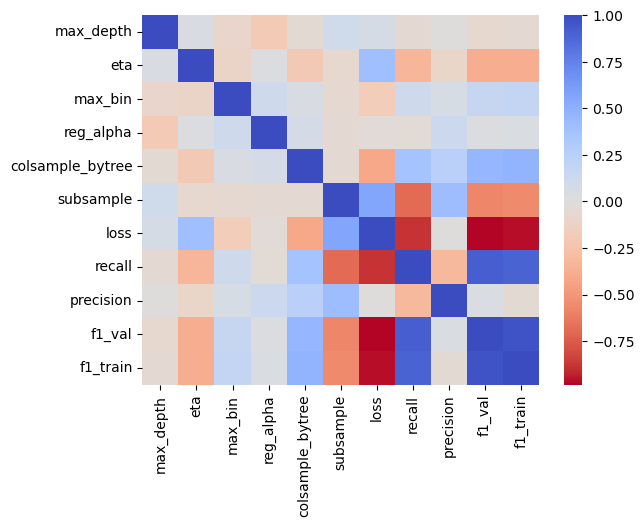

In [64]:
corr = results[['max_depth','eta','max_bin','reg_alpha','colsample_bytree','subsample',
                'loss','recall', 'precision', 'f1_val', 'f1_train']].corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

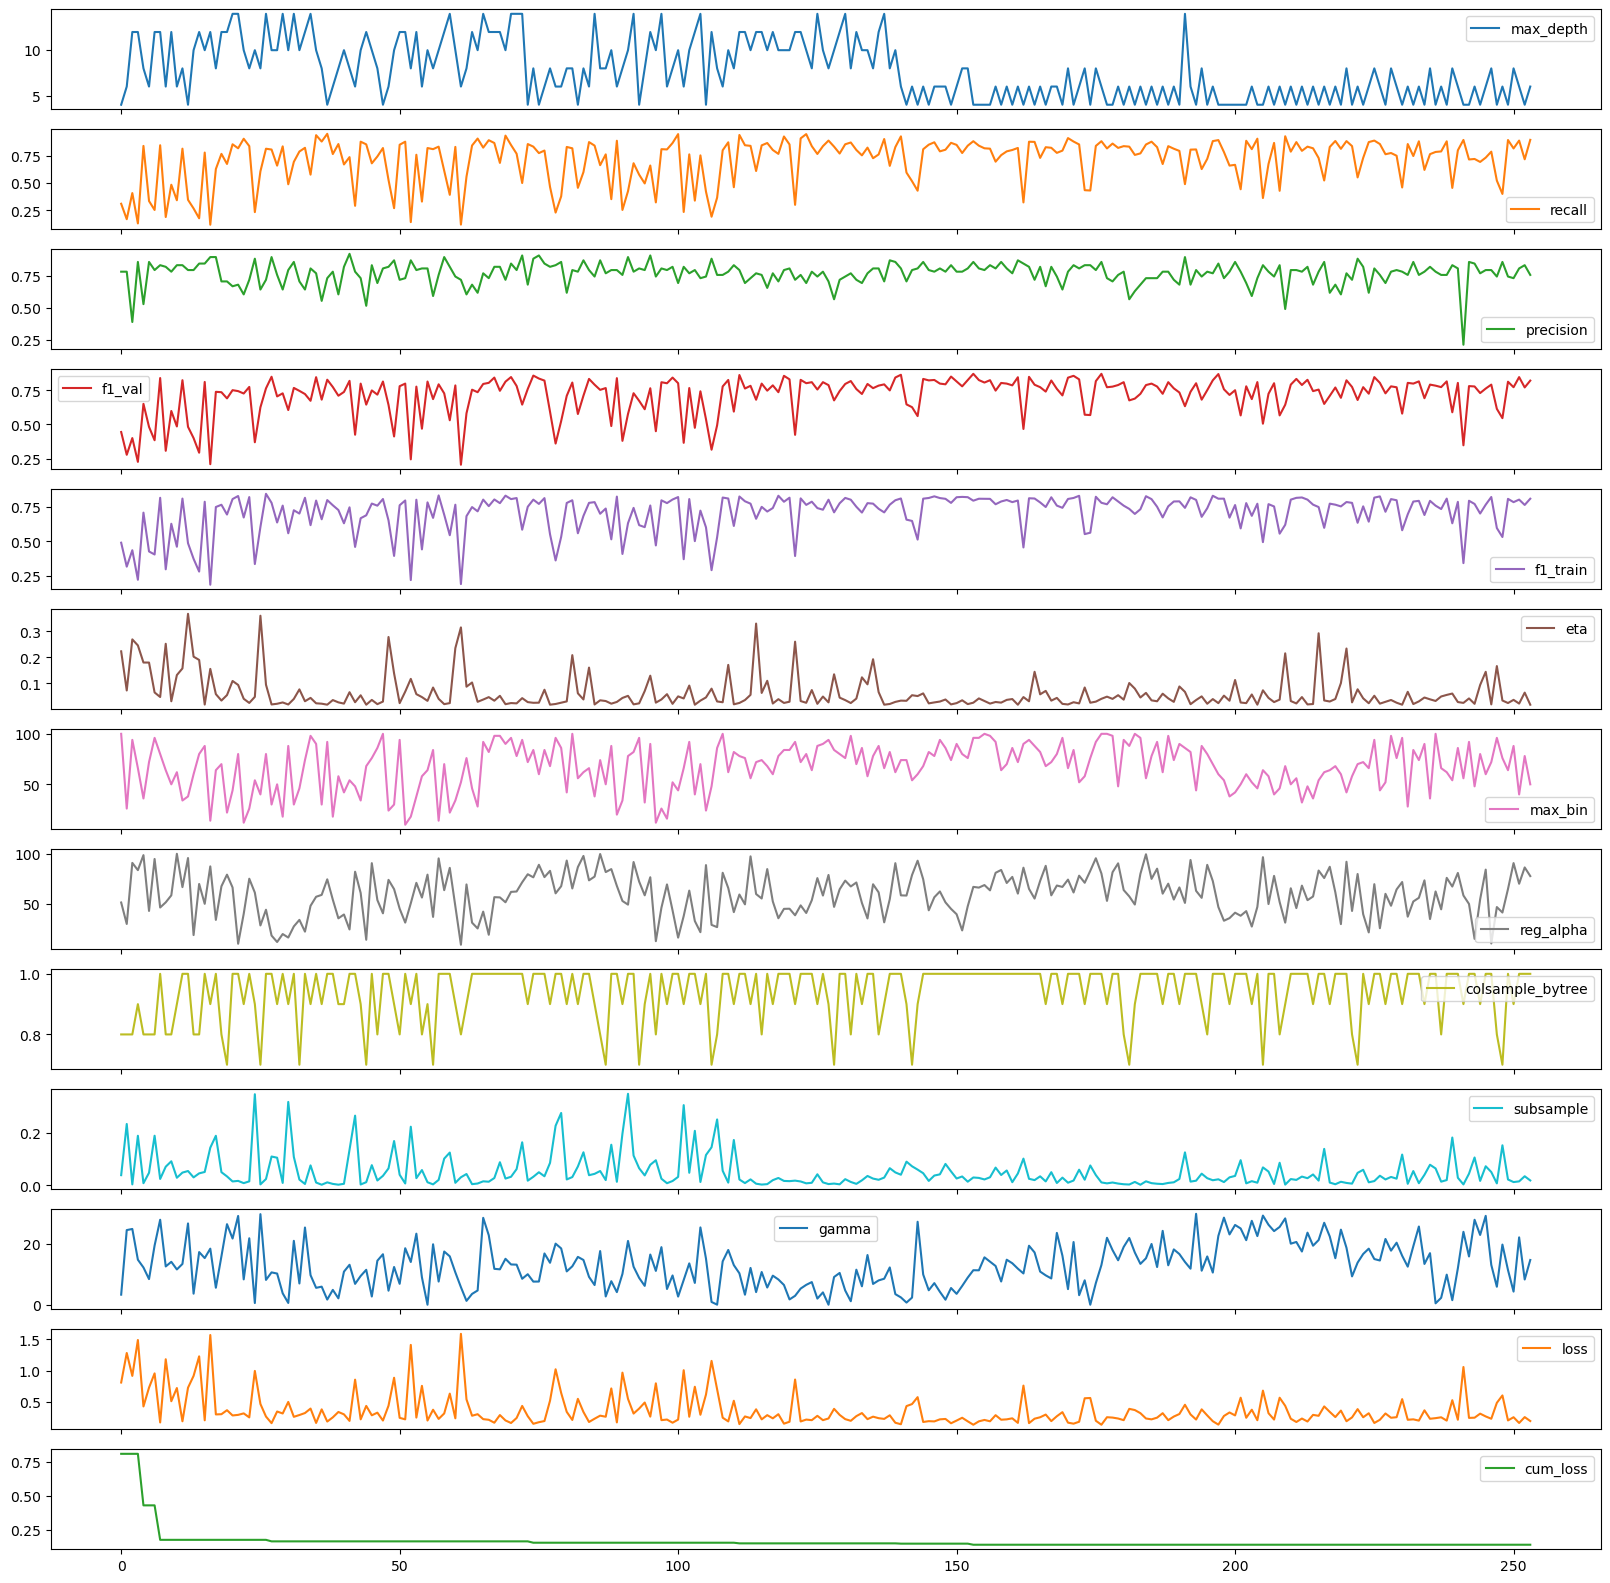

In [65]:
results.plot(subplots=True, figsize=(20, 20))

<Axes: xlabel='eta', ylabel='subsample'>

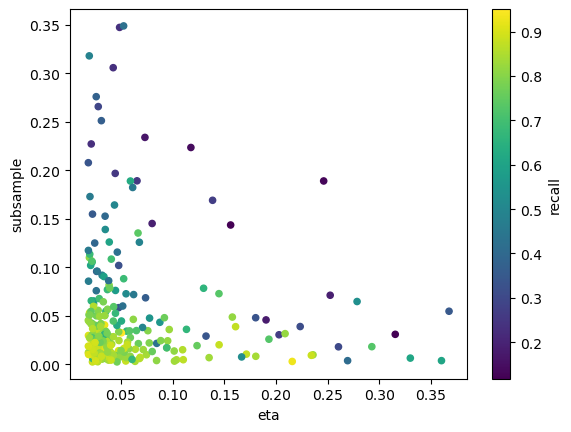

In [68]:
results.plot.scatter(x='eta', y='subsample',c='recall')

In [69]:
results[['recall','precision','f1_val']].describe()

,recall,precision,f1_val
count,254.000000,254.000000,254.000000
mean,0.709907,0.770009,0.712599
std,0.205227,0.087611,0.143720
min,0.117745,0.215190,0.204301
25%,0.627824,0.734177,0.677422
50%,0.797247,0.784810,0.765529
75%,0.849012,0.822785,0.805369
max,0.950820,0.924051,0.871795
